# Bibliotecas e Ambiente

In [ ]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier,
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream, remover_colunas_correlacionadas
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD
from py.models import get_models

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import re
from scipy.stats import linregress

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Streams

## Real

### CICDDoS2019

In [4]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
CICDDoS2019, le_global = criar_stream(
    file_path=FILE_RAW,
    target_label_col=TARGET_COL,
    timestamp_col=TIME_COL,
    cols_para_remover=COLS_NAO_FEATURES,
    features_selecionadas=TOP_20_FEATURES
)

--- Iniciando Pipeline: datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv ---
  [Passo 2/6] Colunas renomeadas.
  [Passo 3/6] Ordenando DataFrame por 'Timestamp'...
  [Passo 4/6] Convertendo valores Infinitos para NaN...
  [Passo 5/6] Removendo colunas, tratando nulos e codificando rótulos...
    - LabelEncoder criado e ajustado. 12 classes encontradas.
    - 7 colunas removidas do conjunto de features.
    - Imputando 3142 valores nulos/infinitos com a MEDIANA...
    - Aplicando seleção de features. Mantendo 20 colunas.
  [Passo 6/6] Criando objeto NumpyStream...
    - Dados finais preparados: X_shape=(93070, 20), y_shape=(93070,).
Stream criado e pronto para uso.


## Sintética

In [3]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Desenvolvimento e Testes

In [50]:
def extrair_rotulo_dinamico(evento_nome):
    if "BENIGN" in evento_nome:
        return "Benigno"
    nome_limpo = re.sub(r'^(ATAQUE_|NIVEL_\d+_|ATAQUE_[A-Z0-9]+_)', '', evento_nome)
    return nome_limpo

def calcular_metricas_avancadas(prediction_history, df_meta, threshold=0.95, N=100):
    metrics_data = []
    
    for _, row in df_meta[df_meta['Tipo'] == 'Ataque'].iterrows():
        start = row['Inicio']
        end = row['Fim']
        nome_evento = extrair_rotulo_dinamico(row['Evento'])
        
        limit = min(len(prediction_history), end)
        if start >= limit: continue
            
        event_preds = prediction_history[start:limit]
        
        n_limit = min(len(event_preds), N)
        acc_at_n = np.mean(event_preds[:n_limit]) * 100
        
        ttt = -1
        window_size_ttt = 100
        if len(event_preds) > window_size_ttt:
            series_preds = pd.Series(event_preds)
            rolling_acc = series_preds.rolling(window=window_size_ttt).mean()
            
            achou = rolling_acc[rolling_acc >= threshold].index
            if len(achou) > 0:
                ttt = achou[0]
        
        slope = 0
        if len(event_preds) > 10:
            y_values = [np.mean(event_preds[:i+1]) for i in range(10, n_limit)]
            x_values = np.arange(len(y_values))
            slope, _, _, _, _ = linregress(x_values, y_values)
            
        metrics_data.append({
            'Evento': nome_evento,
            'Inicio_Real': start,
            'Acc_@_N': f"{acc_at_n:.2f}%",
            'Time_to_95%': ttt if ttt != -1 else "Não atingiu",
            'Slope': f"{slope:.6f}"
        })
        
    return pd.DataFrame(metrics_data)

## Cenário 1

In [51]:
FILE_1 = r'datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_1\metadata_Imunidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv
Iniciando análise de correlação (Limiar: 0.8)...
Removendo 37 colunas redundantes.
Features originais: 80 -> Features após Pearson: 43
Classes identificadas: ['BENIGN' 'DrDoS_LDAP' 'DrDoS_NetBIOS' 'Syn']
======================= LeveragingBagging =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP        19457  94.00%          100 0.001561
DrDoS_NetBIOS        68914  89.00%          120 0.001982
          Syn       118371  92.00%          106 0.002832


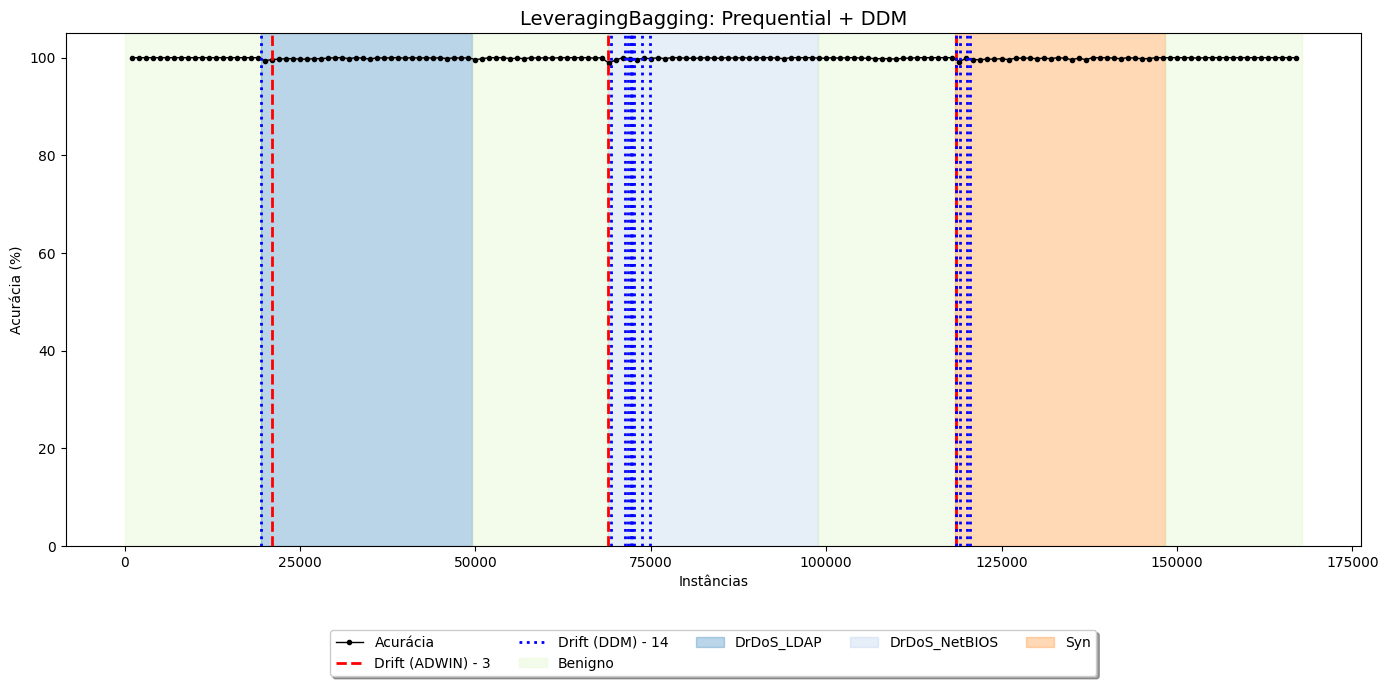

======================= HoeffdingAdaptiveTree =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP        19457  91.00%          122 0.001321
DrDoS_NetBIOS        68914  92.00%          108 0.002189
          Syn       118371  93.00%          104 0.002937


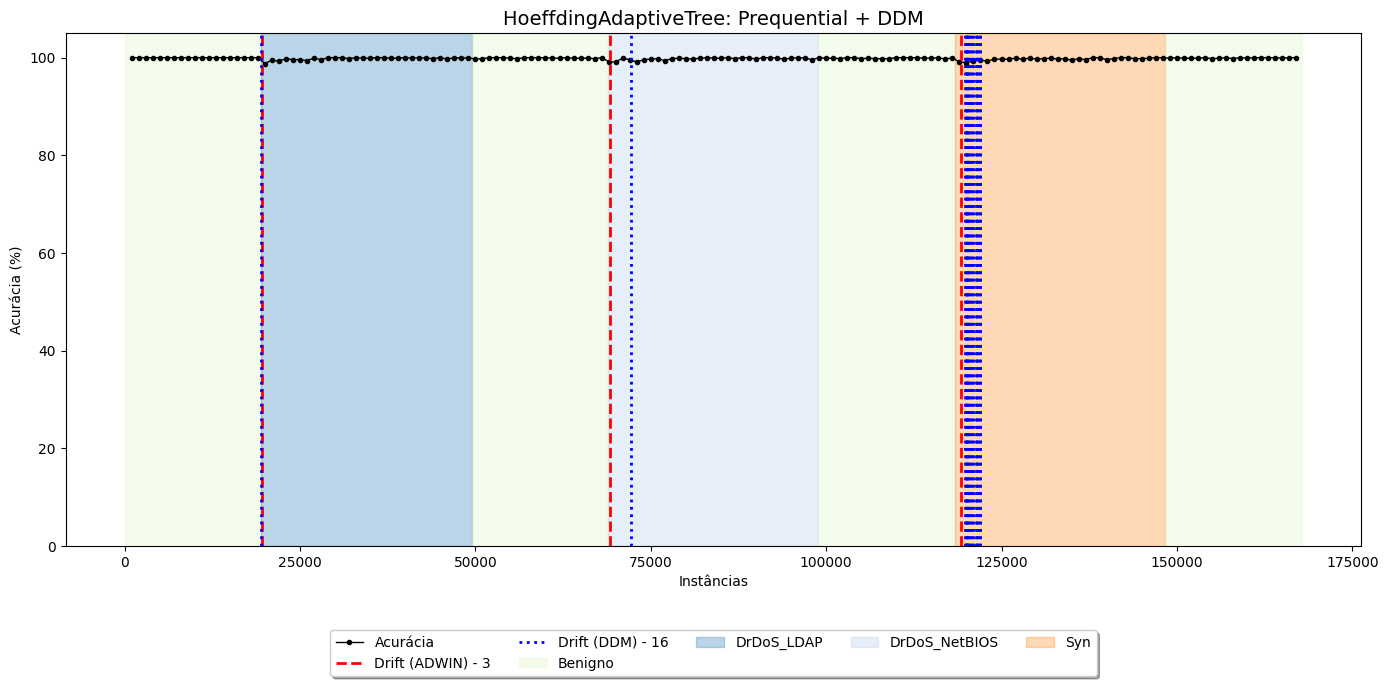

======================= AdaptiveRandomForest =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP        19457  90.00%          122 0.001620
DrDoS_NetBIOS        68914  93.00%          104 0.001836
          Syn       118371  94.00%          100 0.002891


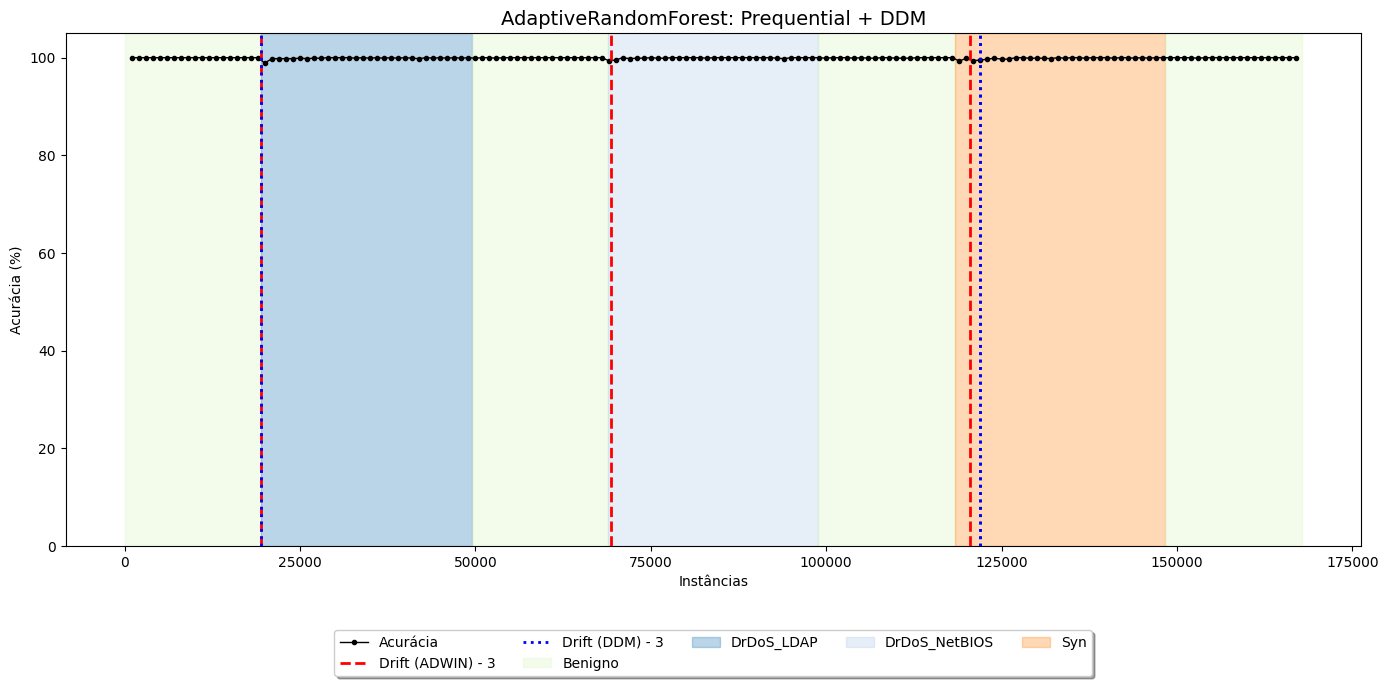

======================= HoeffdingTree =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
   DrDoS_LDAP        19457  94.00%          100  0.001561
DrDoS_NetBIOS        68914  67.00%          174 -0.001969
          Syn       118371  84.00%          133  0.003556


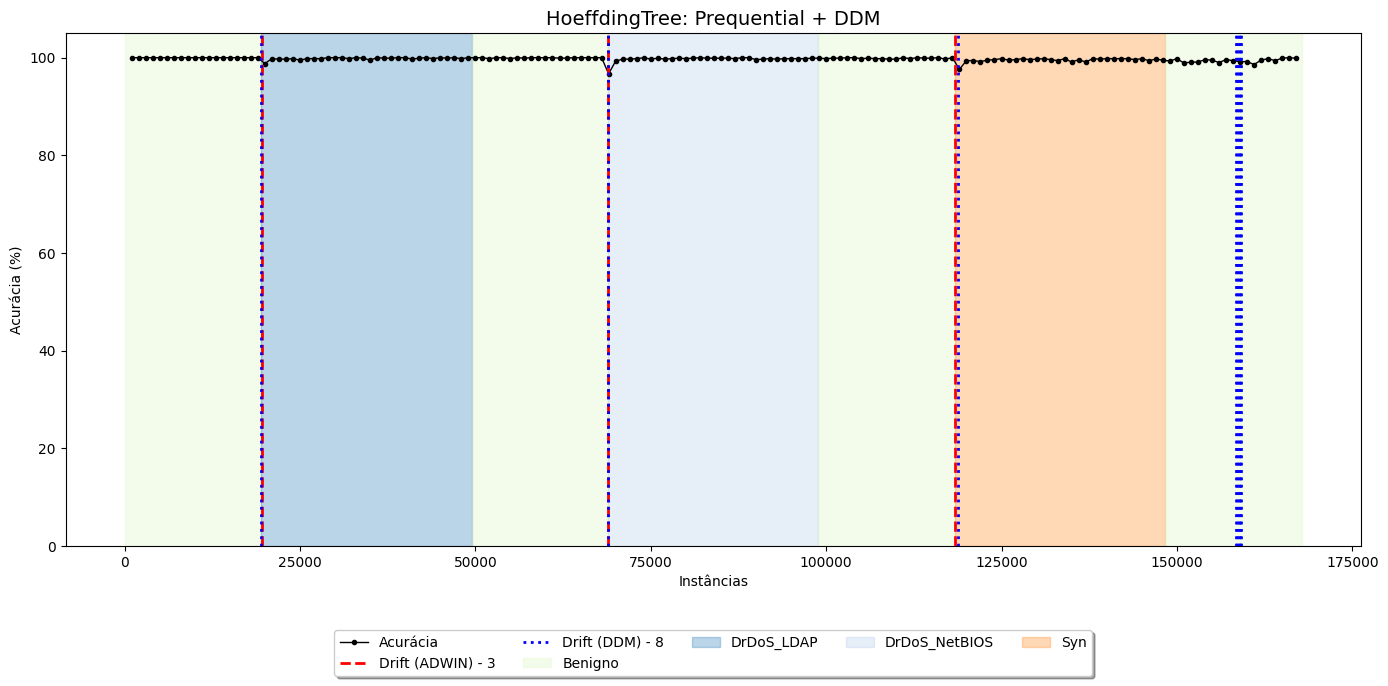

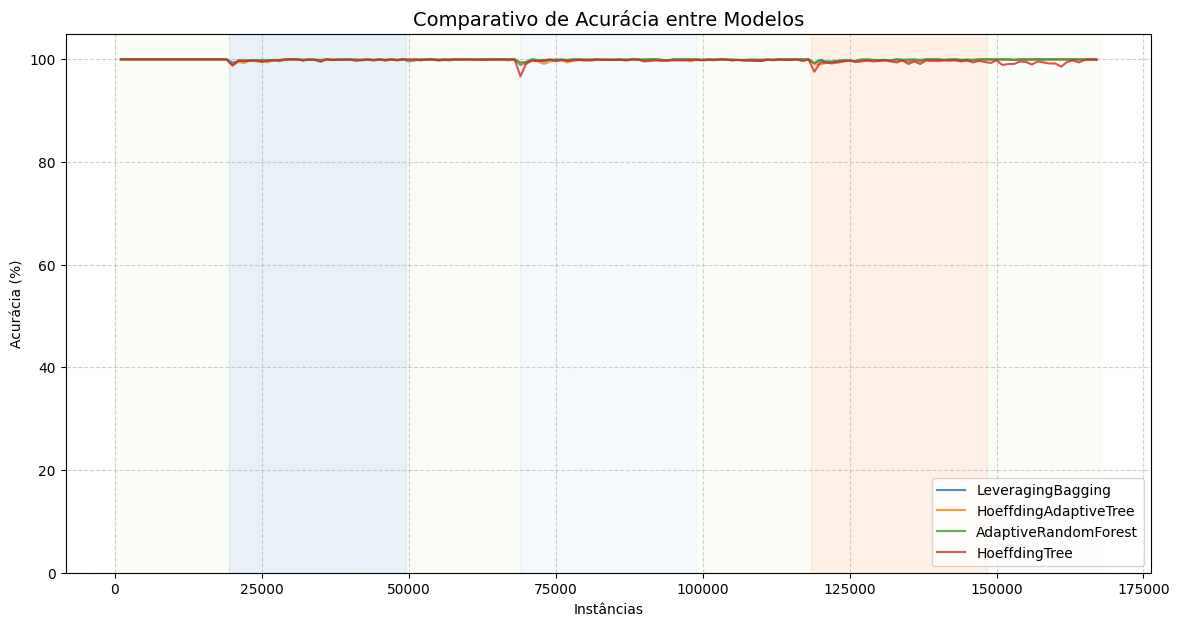

In [52]:
print(f"Carregando Stream: {FILE_1}")
df_raw = pd.read_csv(FILE_1)
df_meta = pd.read_csv(META_FILE)

df_otimizado = remover_colunas_correlacionadas(df_raw, limiar=0.80)

cenario_1, le_global = criar_stream(
    df=df_otimizado, 
    target_label_col="Label" 
)

print(f"Features originais: {df_raw.shape[1]} -> Features após Pearson: {df_otimizado.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário 2

In [53]:
FILE_2 = r'datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_2\metadata_Memoria.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv
Iniciando análise de correlação (Limiar: 0.8)...
Removendo 37 colunas redundantes.
Features originais: 80 -> Features após Pearson: 43
Classes identificadas: ['BENIGN' 'DrDoS_MSSQL' 'DrDoS_UDP']
======================= LeveragingBagging =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP        19457  93.00%          104 0.002431
DrDoS_MSSQL        68914  85.00%          114 0.005924
  DrDoS_UDP       118371  85.00%          123 0.004221


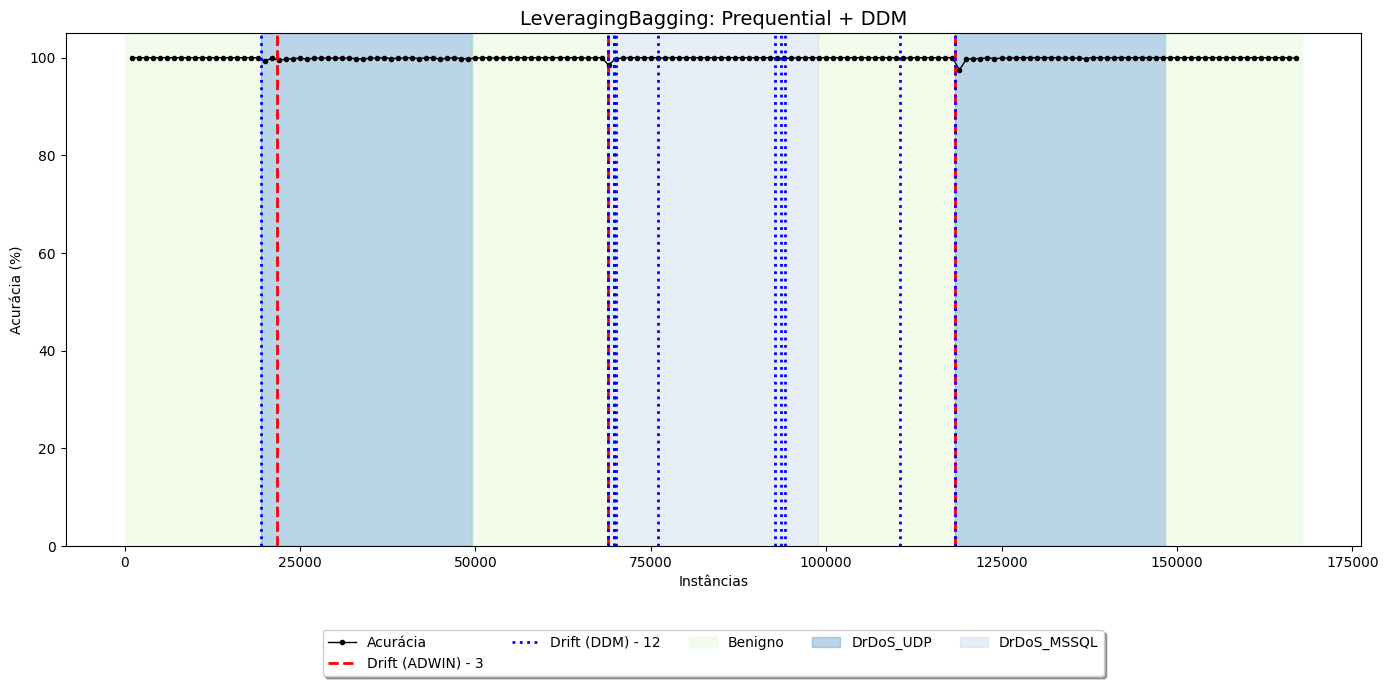

======================= HoeffdingAdaptiveTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP        19457  90.00%          140 0.002101
DrDoS_MSSQL        68914  89.00%          108 0.004415
  DrDoS_UDP       118371  84.00%          202 0.002223


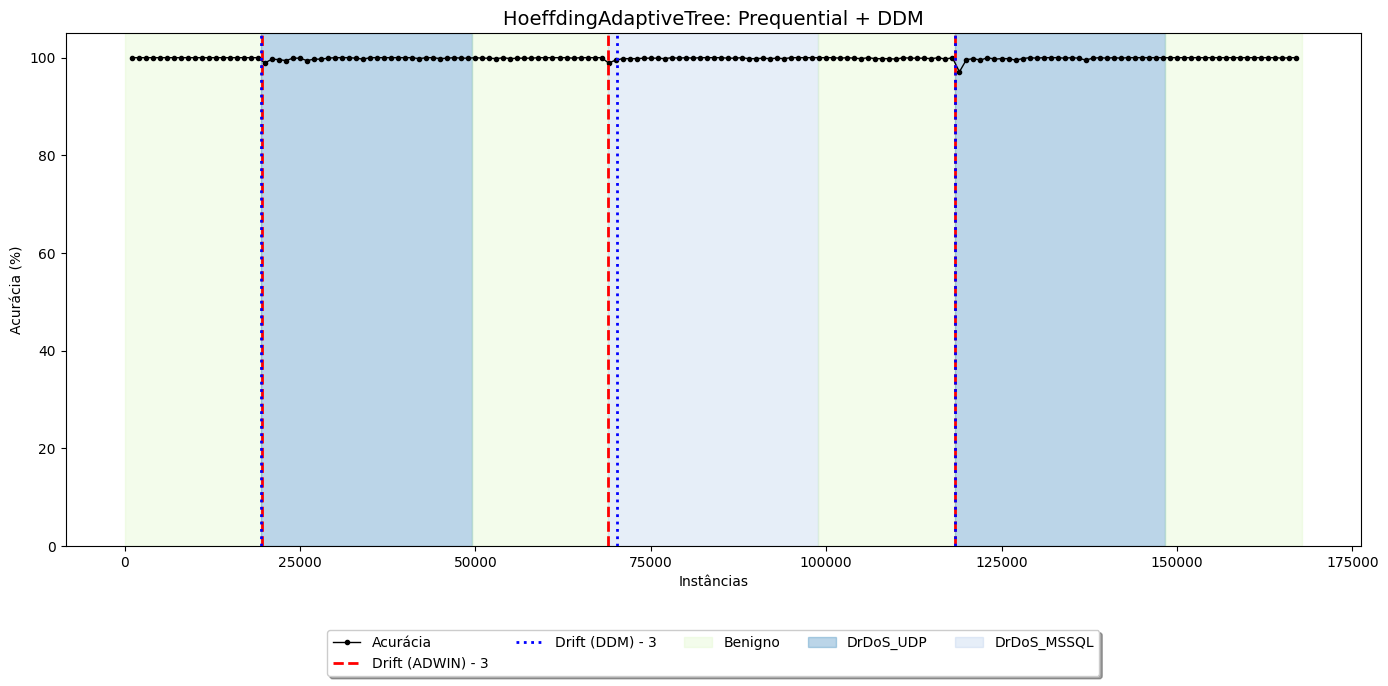

======================= AdaptiveRandomForest =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP        19457  88.00%          142 0.001806
DrDoS_MSSQL        68914  87.00%          113 0.004613
  DrDoS_UDP       118371  88.00%          110 0.004637


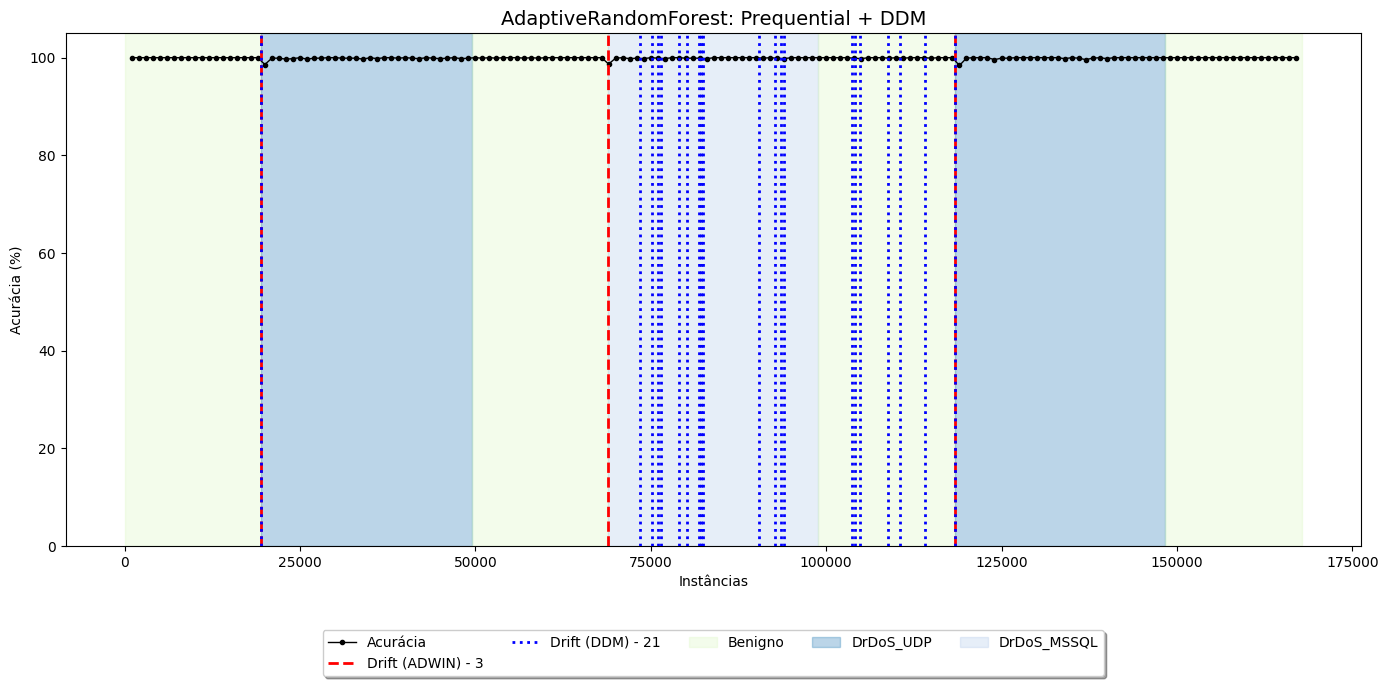

======================= HoeffdingTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP        19457  93.00%          104 0.002432
DrDoS_MSSQL        68914  91.00%          106 0.004837
  DrDoS_UDP       118371  74.00%          147 0.002969


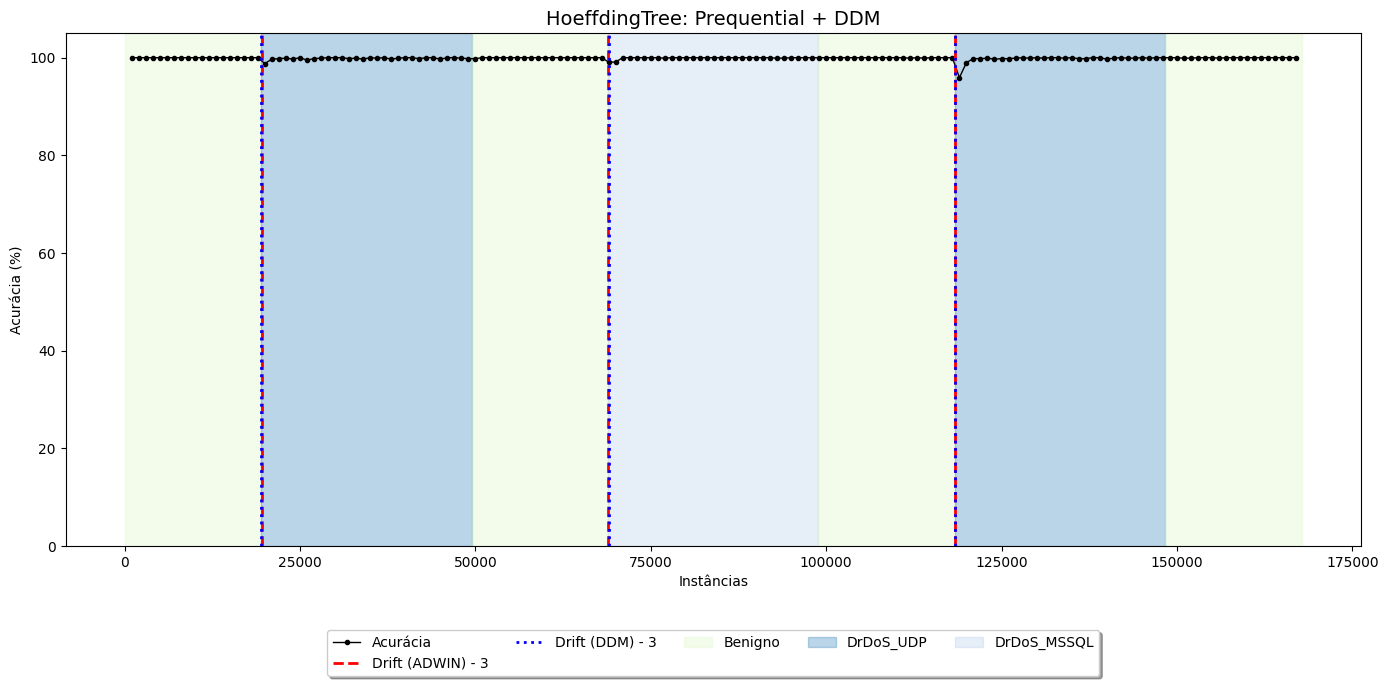

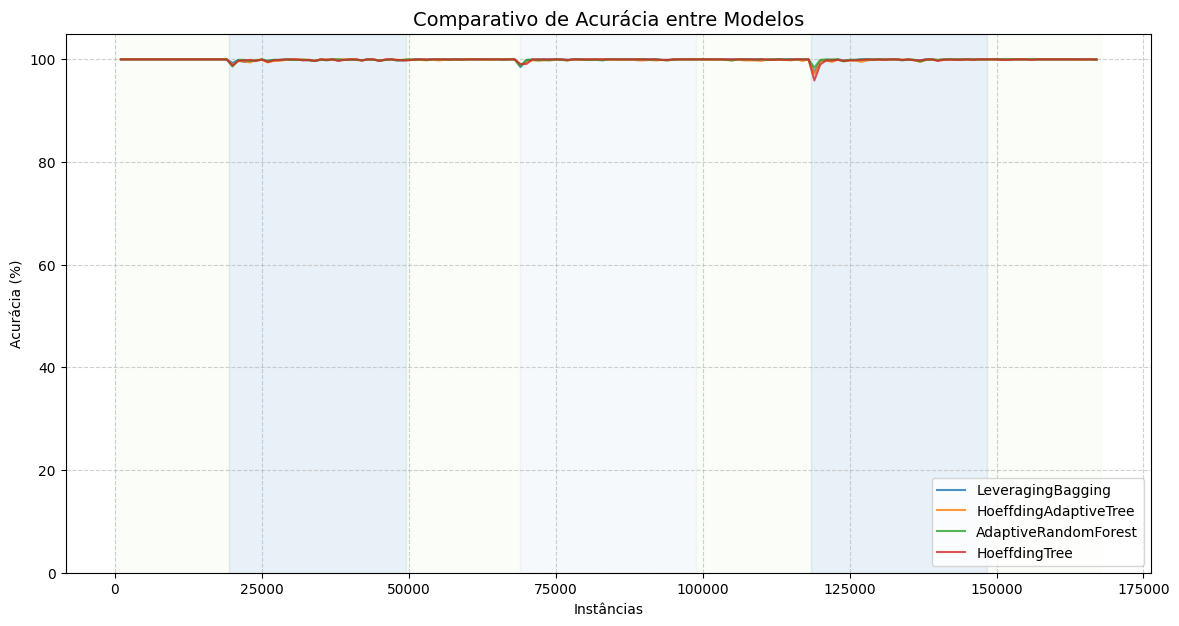

In [54]:
print(f"Carregando Stream: {FILE_2}")
df_raw = pd.read_csv(FILE_2)
df_meta = pd.read_csv(META_FILE)

df_otimizado = remover_colunas_correlacionadas(df_raw, limiar=0.80)

cenario_1, le_global = criar_stream(
    df=df_otimizado, 
    target_label_col="Label" 
)

print(f"Features originais: {df_raw.shape[1]} -> Features após Pearson: {df_otimizado.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário 3

In [55]:
FILE_3 = r'datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_3\metadata_Complexidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv
Iniciando análise de correlação (Limiar: 0.8)...
Removendo 34 colunas redundantes.
Features originais: 80 -> Features após Pearson: 46
Classes identificadas: ['BENIGN' 'DrDoS_DNS' 'DrDoS_NTP' 'UDP']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP        19457  96.00%           99 0.002147
DrDoS_NTP        68914  86.00%          114 0.004788
DrDoS_DNS       118371  77.00%          146 0.004781


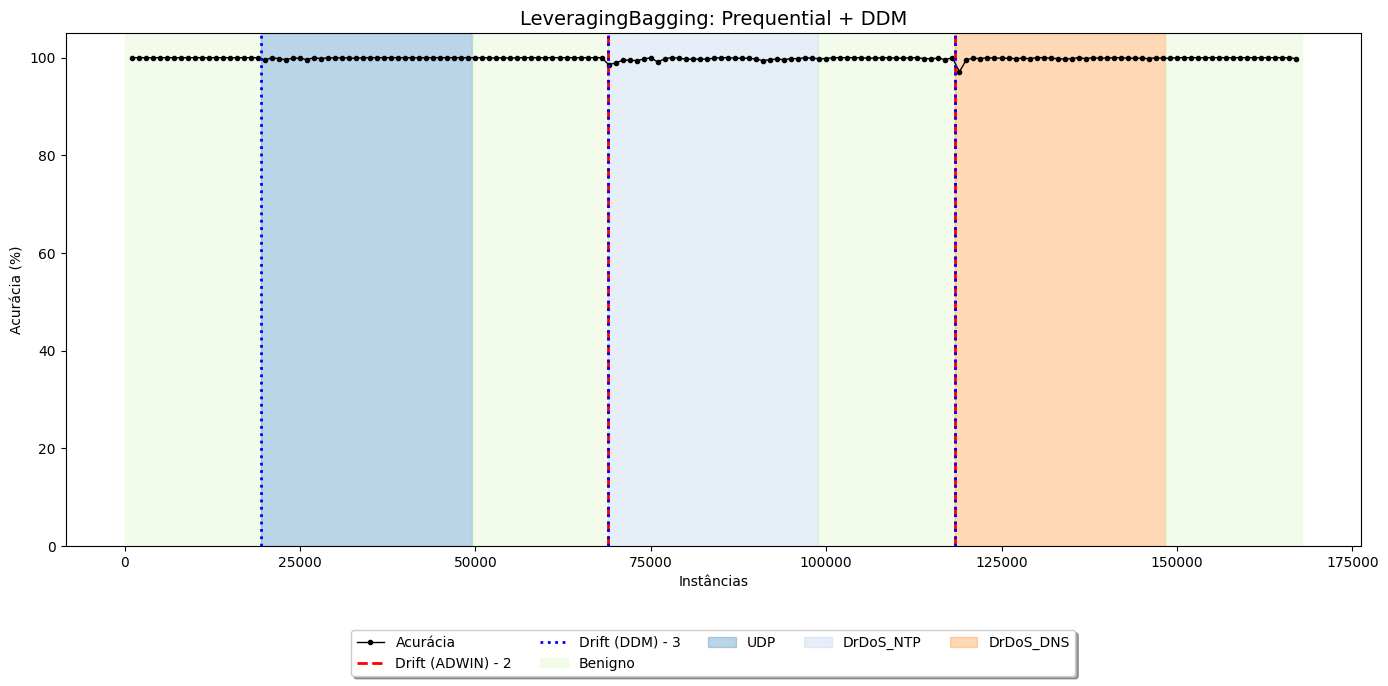

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP        19457  94.00%          100 0.001229
DrDoS_NTP        68914  75.00%          170 0.004486
DrDoS_DNS       118371  86.00%          209 0.002433


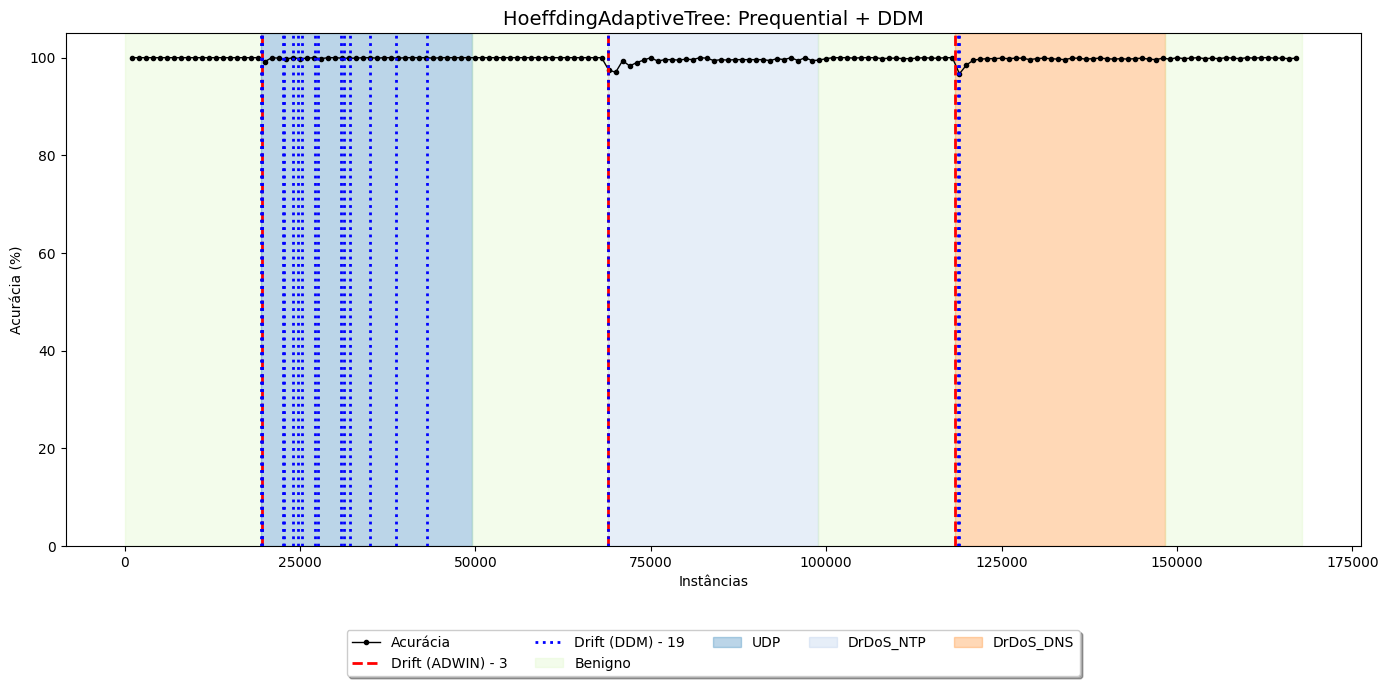

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP        19457  94.00%          100 0.000599
DrDoS_NTP        68914  84.00%          119 0.005640
DrDoS_DNS       118371  88.00%          110 0.004357


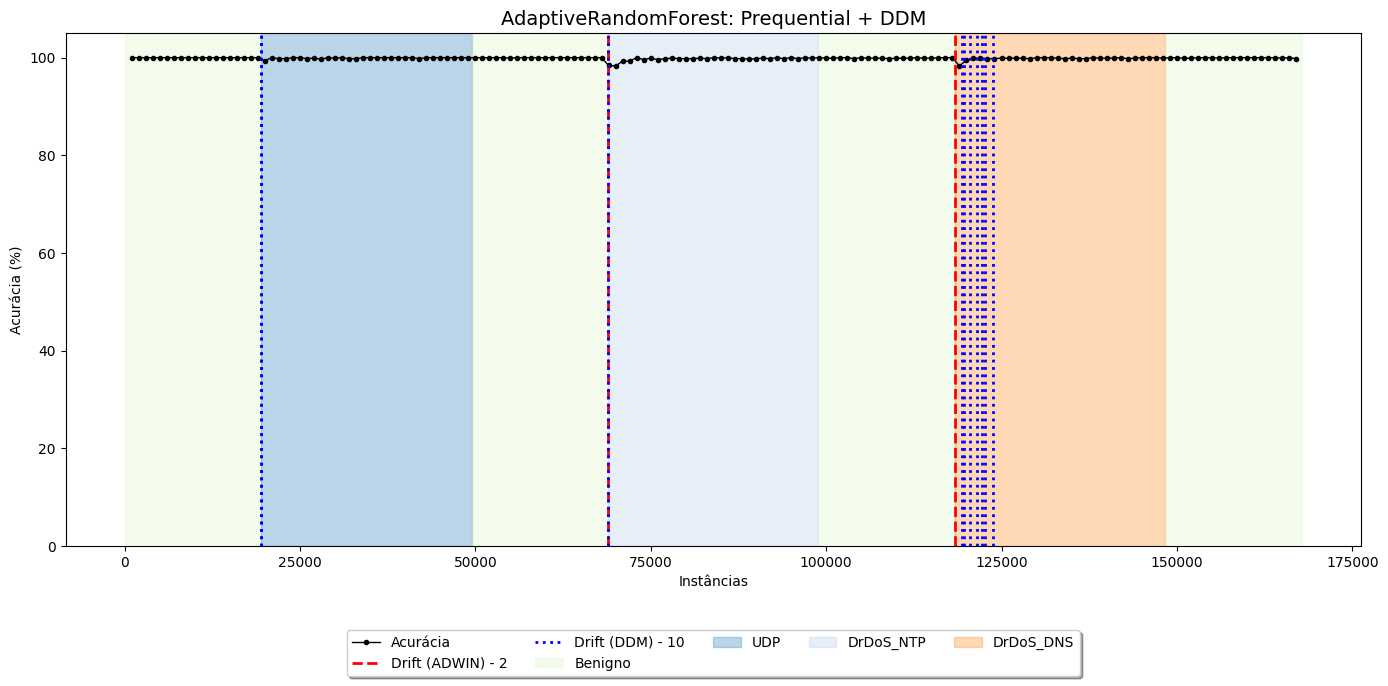

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP        19457  97.00%           99 0.001565
DrDoS_NTP        68914  81.00%          170 0.005504
DrDoS_DNS       118371  84.00%          122 0.004787


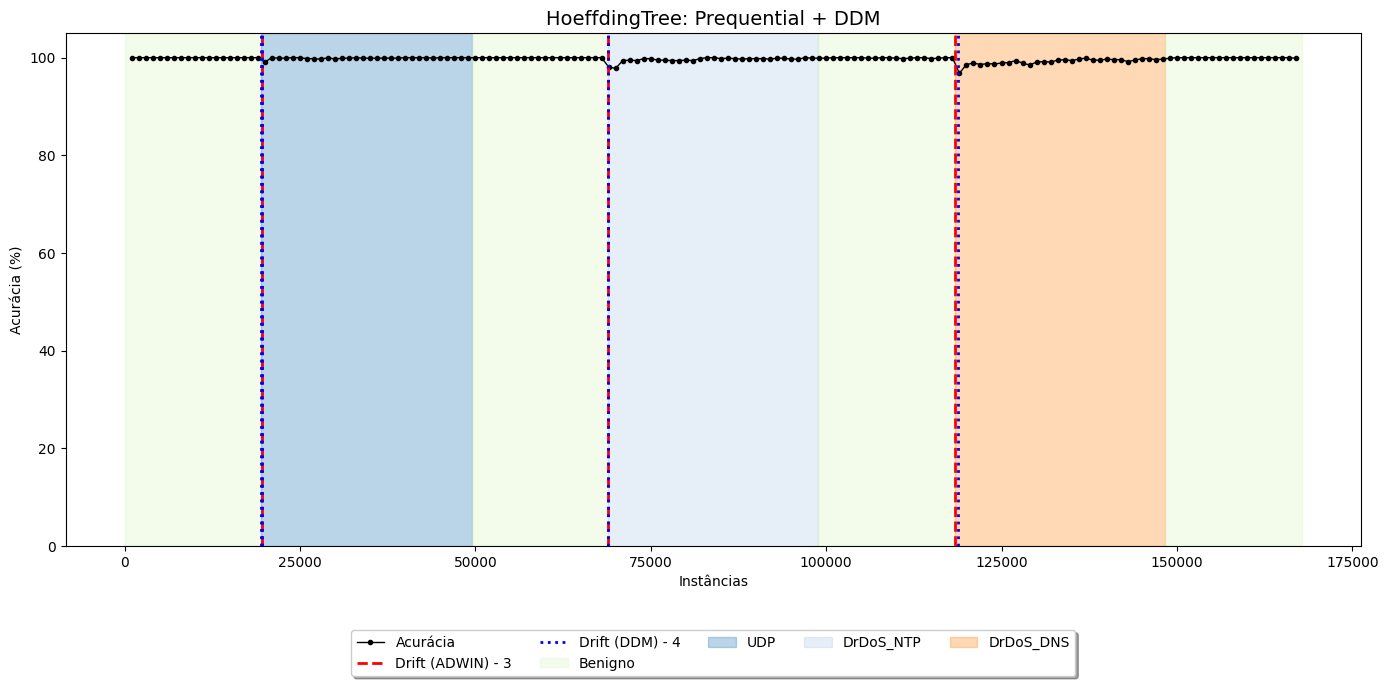

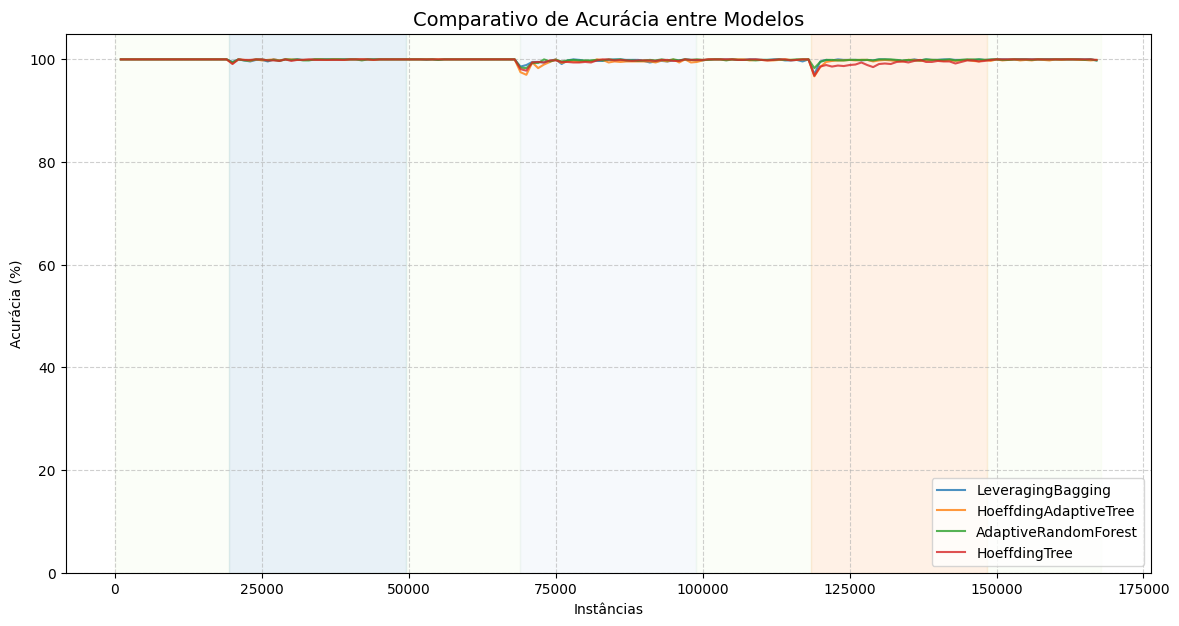

In [56]:
print(f"Carregando Stream: {FILE_3}")
df_raw = pd.read_csv(FILE_3)
df_meta = pd.read_csv(META_FILE)

df_otimizado = remover_colunas_correlacionadas(df_raw, limiar=0.80)

cenario_1, le_global = criar_stream(
    df=df_otimizado, 
    target_label_col="Label" 
)

print(f"Features originais: {df_raw.shape[1]} -> Features após Pearson: {df_otimizado.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()